# Picasso Visualization

This notebook is based on [The Picasso Database Query Optimizer Visualizer](https://dl.acm.org/citation.cfm?id=1921027) by [Jayant R. Haritsa](http://dsl.cds.iisc.ac.in/~haritsa/). **Picasso** is a tool for visually analyzing the behavior of query optimizers. Here, we focus on plan diagrams that show a pictorial enumeration of plan choices over the selectivity space of two predicates according to a given cost model.

Throughout the notebook, we use a simple example query that performs two selections on a given table. We explore when and how to use index accesses for answering the query.

Copyright Marcel Maltry & Jens Dittrich, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

In [21]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

## Cost Model

We first introduce a cost model, based on which we estimate the cost of different physical plans for a given logical plan.

### Cost Model Parameters

Our cost model distinguishes thre types of operations:
* reading values sequentially, e.g. when scanning consecutive values of a list,
* reading values randomly, e.g. when performing binary search on a sorted list,
* performing a comparison, e.g. for checking a predicate on a read value.

Additionally, we use the table size and selectivities of predicates as parameters for our cost model. As the selectivities will be varied for plotting the plan diagram, we do not define them here.

In [22]:
from math import log

seq_read = 1  # sequential read cost
rnd_read = 8  # random read cost
comp = 1  # comparison cost
tab_size = 1000  # table size

### Cost Model Operations

Next, we define the basic operations needed to answer the query. The operations are based on the cost model parameters defined above. The basic operations are
* **`scan_and_compare`:** sequentially reading `num_tups` tuples and performing one comparison on each tuple,
* **`scan_and_double_compare`:** sequentially reading `num_tups` tuples and perfoming two comparisons on each tuple,
* **`scan_and_cond_double_compare`:** sequentially reading `num_tups` tuples and performing one comparison on each tuple and a second comparison in `prob * num_tups` cases,
* **`binary_search`:** performing binary search on the table resulting in $log_2(tab\_size)$ random reads and comparisons.

In [23]:
def scan_and_compare(num_tups):
    return (seq_read + comp) * num_tups

def scan_and_double_compare(num_tups):
    return (seq_read + 2*comp) * num_tups

def scan_and_cond_double_compare(num_tups, prob):
    return (seq_read + comp) * num_tups + comp * (prob * num_tups)

def binary_search():
    return (rnd_read + comp) * log(tab_size, 2)

## Query

For demonstration purposes, we choose a simple query consisting on two selection on a base table. We define the query as the following  expression in relational algebra:
$$\sigma_{q}\big( \sigma_{p} (R) \big).$$

### Logical Plan

The tree represenation of the logical plan is depicted below.

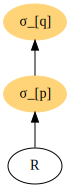

In [24]:
from ra.relation import Relation
from ra.operators_log import LeafOperator, Selection
from graphviz import Source

R = LeafOperator(Relation('R',[('id',int)]))
Sel1 = Selection(R, 'p')
Sel2 = Selection(Sel1, 'q')

log_plan = Sel2.get_graph()
Source(log_plan)

### Physical Plans

For our physical plan, we assume that we have indexes available for both predicates $p$ and $q$. We further assume, that our indexes are implemented as a sorted list of tuples in the table representing Relation $R$. Note that this implies data redundancy and is implemented differently in practice but suffices to show how plan diagrams can be used to analyze query optimizers.

We define the following physical plans for answering the query and their respective cost function based on the selectivities `sel_p` and `sel_q` of predicates $p$ and $q$:
**Full Scan**
* **`naive_full_scan`:** fully scan $R$ and check both predicates,
* **`full_scan_check_first_p`:** fully scan $R$ and check $p$ first, only check $q$ if $p$ holds,
* **`full_scan_check_first_q`:** similar to `full_scan_check_first_p` but checking predicate $q$ first,

**Binary Search and Scan**
* **`index_search_p_and_scan`:** use the index on $p$ by performing binary search to find the beginning of all tuples that satisfy $p$, then scan and check both predicates (Note that here, we need to check both predicates since we use the index and can stop as soon as $p$ does not hold for the first time),
* **`index_search_q_and_scan`:** similar to `index_search_p_and_scan` but using the index on $q$,

**Double Binary Search and Scan**
* **`double_index_search_p_and_scan`:** use the index on $p$ by performing two binary searches to find the beginning and the end of all tuples that satisfy $p$, then scan the area in-between and only check $q$ (Note that we do not have to check $p$ since it holds for all tuples in the area),
* **`double_index_search_q_and_scan`:** similar to `double_index_search_p_and_scan` but using the index on $q$.

In [25]:
# full scan and check both predicates
def naive_full_scan(sel_p, sel_q):
    return scan_and_double_compare(tab_size)
# full scan and only check second predicate if first matches
def full_scan_check_first_p(sel_p, sel_q):
    return scan_and_cond_double_compare(tab_size, sel_p)

def full_scan_check_first_q(sel_p, sel_q):
    return scan_and_cond_double_compare(tab_size, sel_q)


# use index to find beginning and check both attributes
def index_search_p_and_scan(sel_p, sel_q):
    return binary_search() + scan_and_double_compare(sel_p * tab_size)

def index_search_q_and_scan(sel_p, sel_q):
    return binary_search() + scan_and_double_compare(sel_q * tab_size)


# use index to find beginning and end check second attribute in between
def double_index_search_p_and_scan(sel_p, sel_q):
    return 2 * binary_search() + scan_and_compare(sel_p * tab_size)

def double_index_search_q_and_scan(sel_p, sel_q):
    return 2 * binary_search() + scan_and_compare(sel_q * tab_size)

## Visualization

Next, we visualize the plan costs. We distinguish between two strategies for visualizing plan costs:
* **Fixing one selectivity:** set the selectivity of one predicate (here $q$) and vary the selectivity of the other predicate from 0 to 1,
* **Varying both selectivities:** vary the selectivities of both predicates from 0 to 1.

We begin by defining a list of nice colors to be used in the plots.

In [26]:
# define a list of nice colors
color_list = [
    '#0a330f', # super dark green
    '#713b87', # dark purple
    '#c49cd3', # light purple
    '#2448bc', # dark blue
    '#839ae7', # light blue
    '#c12525', # dark red
    '#e77e7e', # light red
]

### Fixing One Selectivity

For this strategy, we can best visualize the plan costs (and thus the optimal plan according to our cost functions) with a line plot that shows the cost estimate for varying selectivities of $p$.

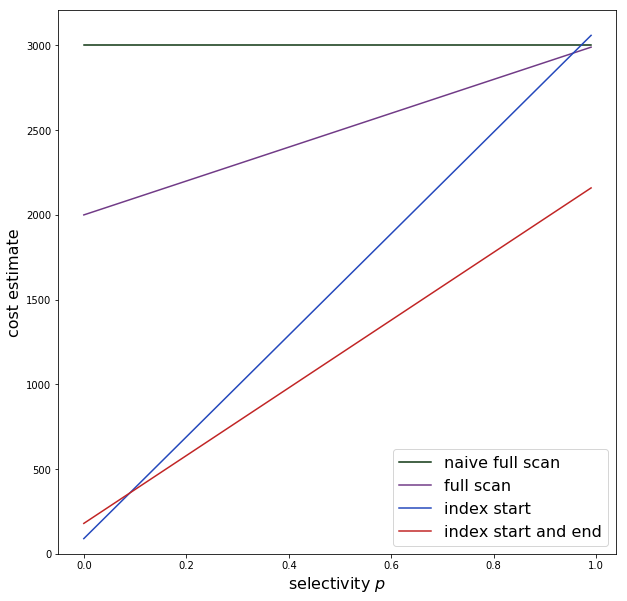

In [27]:
# define selectivities
sels_p= np.arange(0, 1, 0.01)  # vary p's selectivity
sel_q = 0.7  # fix q's selectivity

# compute costs for varying selectivities of p
y0 = [naive_full_scan(sel_p, sel_q) for sel_p in sels_p]
y1 = [full_scan_check_first_p(sel_p, sel_q) for sel_p in sels_p]
y2 = [index_search_p_and_scan(sel_p, sel_q) for sel_p in sels_p]
y3 = [double_index_search_p_and_scan(sel_p, sel_q) for sel_p in sels_p]

# plot the costs
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sels_p, y0, color=color_list[0], label='naive full scan')
ax.plot(sels_p, y1, color=color_list[1], label='full scan')
ax.plot(sels_p, y2, color=color_list[3], label='index start')
ax.plot(sels_p, y3, color=color_list[5], label='index start and end')

# define limits, labels, and legend
fontsize = 16
ax.set_ylim(bottom=0)
ax.set_xlabel('selectivity $p$', fontsize=fontsize)
ax.set_ylabel('cost estimate', fontsize=fontsize)
ax.legend(fontsize=fontsize)

Note that depending on the selectivity of $p$ different plans should be preferred by the query optimizer. The only plan that should never be used is the naive full scan since there is always a better plan.

### Varying Both Selectivities

For this strategy, we cannot visualize the individual plan costs in a two-dimensional plot. Thus, we visualize the best plan according to the cost functions in the selectivity space as a so called *plan diagram*. In this diagram, each color represents one plan. For a given pair of selectivities, we can then determine the physical plan with the lowest cost.

We start by defining a list of all plans, that we want to be incorporated into the diagram. We then define a function that returns the index of the best plan for two given selectivities.

In [28]:
plans = [
    naive_full_scan,
    full_scan_check_first_p,
    full_scan_check_first_q,
    index_search_p_and_scan,
    index_search_q_and_scan,
    double_index_search_p_and_scan,
    double_index_search_q_and_scan
]

plan_labels = [
    'naive full scan',
    'full scan ($p$)',
    'full scan ($q$)',
    'index start ($p$)',
    'index start ($q$)',
    'index start and end ($p$)',
    'index start and end ($q$)',
]

def best_plan_index(sel_p, sel_q):
    cost = [plan(sel_p, sel_q) for plan in plans]
    return cost.index(min(cost))

Finally, we define a function that creates the plan diagram based on varying selectivities for a list of given plans.

In [29]:
def plot_plan_diagram(plans, plan_lables, num_points, ax, color_list):
    
    # define sthe selectivities and a grid of optimal plans
    opt_plans = np.zeros((num_points, num_points))
    sels_p = np.arange(0, 1, 1/num_points)
    sels_q = np.arange(0, 1, 1/num_points)
    
    # compute the index of the best plan for all combinations of selectivities
    for x in range(0, len(sels_p)):
        for y in range(0, len(sels_q)):
            opt_plans[y][x] = best_plan_index(sels_p[x], sels_q[y])
    
    # create a discrete colormap
    cmap = colors.ListedColormap(color_list)
    bounds = np.arange(0, len(color_list)+0.1, 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # plot the plan diagram
    ax.imshow(opt_plans, cmap=cmap, origin='lower', norm=norm)
    
    # define ticks
    fontsize = 16
    num_ticks = 10
    xticks = np.arange(0, num_points, num_points/num_ticks)
    yticks = np.arange(0, num_points, num_points/num_ticks)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    xticklabels = np.around(np.arange(0, 1, 1/num_ticks), decimals=1)
    yticklabels = np.around(np.arange(0, 1, 1/num_ticks), decimals=1)
    ax.set_xticklabels(xticklabels, fontsize=fontsize*0.5)
    ax.set_yticklabels(yticklabels, fontsize=fontsize*0.5)
    
    # define labels
    ax.set_xlabel('selectivity $p$', fontsize=fontsize)
    ax.set_ylabel('selectivity $q$', fontsize=fontsize)
    
    # define legend
    proxy = [plt.Rectangle((0,0),1,1, color=cmap(norm(i))) for i in range(0, len(plans))]
    labels = plan_labels
    plt.legend(proxy, labels, loc='upper left', fontsize=fontsize)

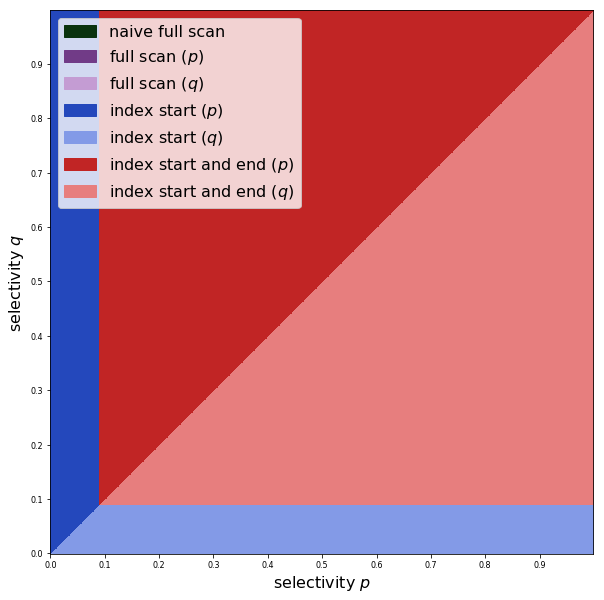

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_plan_diagram(plans, plan_labels, 500, ax, color_list)

Depending on the parameters chosen above, we see that whenever there is a difference in selectivities, we prefer to use an index on the predicate or check the predicate that is more selective. In doing so, we can rule avoid additional comparisons (full scan) or decrease the size of the area that has to be scanned (index access).